# Import and analyze data

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import glob
import os
from scipy.signal import find_peaks, lti, lsim, bode
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pickle

# Set the path to the directory containing the CSV files. Drag and drop all raw data into runtime before running.
path = '/content/'
all_files = glob.glob(os.path.join(path, "*_hz.CSV"))

# Sort files to ensure they are in the correct order
all_files.sort(key=lambda x: int(os.path.basename(x).split('_')[0]))

# Minimum time to start looking for peaks to avoid initial noise
min_time_threshold = 0.5  # Adjust this value as needed

# Define the peak range to be used for trimming
start_peak = 1
end_peak = 25

# Prepare a list to store trimmed data
trimmed_data = []

# Part 1: Data Trimming
for file in all_files:
    # Import the data
    data = pd.read_csv(file, skiprows=41)

    # Extract the relevant columns
    time = data.iloc[:, 1]
    pressure1 = data.iloc[:, 2]
    pressure2 = data.iloc[:, 3]

    # Filter out the initial noise
    valid_indices = time > min_time_threshold
    filtered_time = time[valid_indices]
    filtered_pressure1 = pressure1[valid_indices]
    filtered_pressure2 = pressure2[valid_indices]

    # Find the peaks in pressure 1
    peaks1, _ = find_peaks(filtered_pressure1)

    # Ensure we have enough peaks
    if len(peaks1) >= end_peak:
        # Determine the time range between the specified peaks
        start_index = peaks1[start_peak-1]
        end_index = peaks1[end_peak-1]
        peak_time_range = (filtered_time.iloc[start_index], filtered_time.iloc[end_index])

        # Trim the data based on the peak time range
        trimmed_indices = (filtered_time >= peak_time_range[0]) & (filtered_time <= peak_time_range[1])
        trimmed_time = filtered_time[trimmed_indices]
        trimmed_pressure1 = filtered_pressure1[trimmed_indices]
        trimmed_pressure2 = filtered_pressure2[trimmed_indices]

        # Store trimmed data
        trimmed_data.append({
            'file': file,
            'trimmed_time': trimmed_time,
            'trimmed_pressure1': trimmed_pressure1,
            'trimmed_pressure2': trimmed_pressure2
        })


# Analysis

In [ ]:
analysis_results = []

for data in trimmed_data:
    file = data['file']
    trimmed_time = data['trimmed_time']
    trimmed_pressure1 = data['trimmed_pressure1']
    trimmed_pressure2 = data['trimmed_pressure2']

    # Find the peaks and valleys in the trimmed data
    peaks1_trimmed, _ = find_peaks(trimmed_pressure1)
    valleys1_trimmed, _ = find_peaks(-trimmed_pressure1)
    peaks2_trimmed, _ = find_peaks(trimmed_pressure2)
    valleys2_trimmed, _ = find_peaks(-trimmed_pressure2)

    # Calculate mean peak and mean valley for both pressures
    mean_peak1 = trimmed_pressure1.iloc[peaks1_trimmed].mean() if len(peaks1_trimmed) > 0 else np.nan
    mean_valley1 = -trimmed_pressure1.iloc[valleys1_trimmed].mean() if len(valleys1_trimmed) > 0 else np.nan
    mean_amplitude1 = (mean_peak1 + mean_valley1) / 2 if not np.isnan(mean_peak1) and not np.isnan(mean_valley1) else np.nan

    mean_peak2 = trimmed_pressure2.iloc[peaks2_trimmed].mean() if len(peaks2_trimmed) > 0 else np.nan
    mean_valley2 = -trimmed_pressure2.iloc[valleys2_trimmed].mean() if len(valleys2_trimmed) > 0 else np.nan
    mean_amplitude2 = (mean_peak2 + mean_valley2) / 2 if not np.isnan(mean_peak2) and not np.isnan(mean_valley2) else np.nan

    amplitude_ratio = mean_amplitude2 / mean_amplitude1 if not np.isnan(mean_amplitude1) else np.nan

    # Calculate the frequency of pressure 1
    time_period = trimmed_time.iloc[peaks1_trimmed[1]] - trimmed_time.iloc[peaks1_trimmed[0]]  # Assuming a uniform frequency
    frequency1 = 1 / time_period

    # Calculate the phase shift
    phase_shifts = []
    for peak_index in range(min(len(peaks1_trimmed), len(peaks2_trimmed))):
        if peak_index + 1 < len(peaks1_trimmed) and peak_index + 1 < len(peaks2_trimmed):
            time_diff = trimmed_time.iloc[peaks1_trimmed[peak_index + 1]] - trimmed_time.iloc[peaks2_trimmed[peak_index + 1]]
            phase_shift = 360 * time_diff * frequency1 - 360
            phase_shifts.append(phase_shift)

    mean_phase_shift = np.mean(phase_shifts) if phase_shifts else np.nan

    analysis_results.append({
        'file': file,
        'frequency1': frequency1,
        'amplitude1': mean_amplitude1,
        'amplitude2': mean_amplitude2,
        'amplitude_ratio': amplitude_ratio,
        'mean_phase_shift': mean_phase_shift,
        'trimmed_time': trimmed_time,
        'trimmed_pressure1': trimmed_pressure1,
        'trimmed_pressure2': trimmed_pressure2,
        'peaks1': peaks1_trimmed,
        'valleys1': valleys1_trimmed,
        'peaks2': peaks2_trimmed,
        'valleys2': valleys2_trimmed
    })


# Save analysis results for further use
with open('analysis_results.pkl', 'wb') as f:
    pickle.dump(analysis_results, f)

# Create a DataFrame to display results
results_df = pd.DataFrame({
    'File': [os.path.basename(result['file']) for result in analysis_results],
    'Frequency (Hz)': [result['frequency1'] for result in analysis_results],
    'Amplitude 1 (mean)': [result['amplitude1'] for result in analysis_results],
    'Amplitude 2 (mean)': [result['amplitude2'] for result in analysis_results],
    'Amplitude Ratio': [result['amplitude_ratio'] for result in analysis_results],
    'Mean Phase Shift (degrees)': [result['mean_phase_shift'] for result in analysis_results]
})

# Display the results table
print(results_df)


         File  Frequency (Hz)  Amplitude 1 (mean)  Amplitude 2 (mean)  \
0    1_hz.CSV        1.000000           46.666966           45.695417   
1    2_hz.CSV        2.020202           49.469094           46.154167   
2    3_hz.CSV        3.001200           52.429937           45.654167   
3    4_hz.CSV        4.006410           58.154801           45.816458   
4    5_hz.CSV        5.000000           64.457092           45.949792   
5    6_hz.CSV        6.009615           73.106277           46.703958   
6    7_hz.CSV        7.002801           84.634312           48.144792   
7    8_hz.CSV        8.012821           97.976277           49.428750   
8    9_hz.CSV        8.960573          105.985616           47.276042   
9   10_hz.CSV       10.000000          102.604746           40.485208   
10  11_hz.CSV       10.989011           89.326848           31.190833   
11  12_hz.CSV       12.019231           72.739004           22.354583   
12  13_hz.CSV       13.020833           57.356250  

# Calculate w_n and zeta

Optimized natural frequency: 10.333074697222552 Hz
Optimized damping ratio: 1.2386934673366834


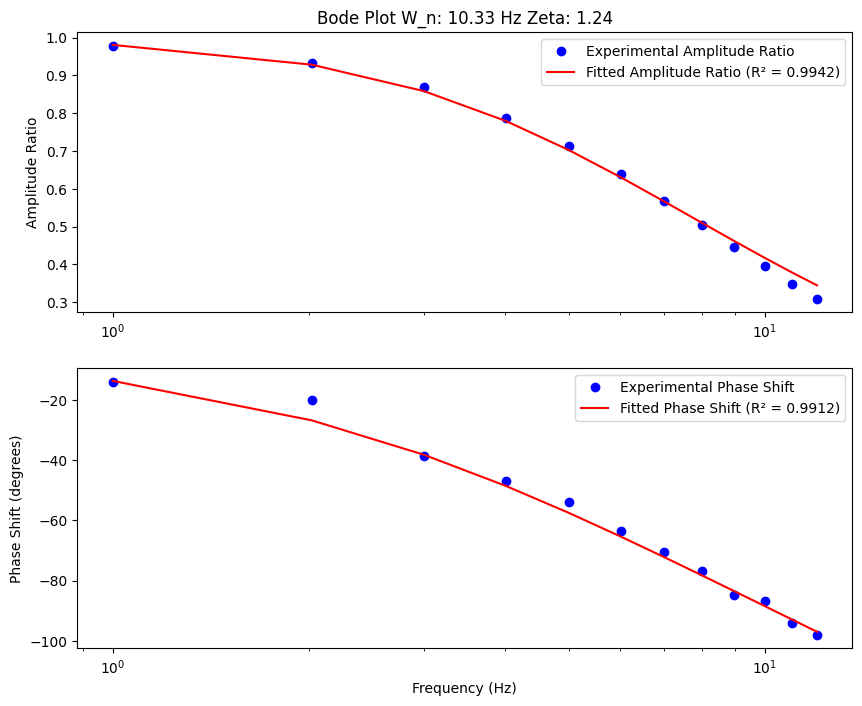

In [ ]:
# Define the frequency range to be used for system analysis
frequency_min = 0  # Minimum frequency in Hz
frequency_max = 13  # Maximum frequency in Hz

# Filter results based on the frequency range
filtered_results = results_df[(results_df['Frequency (Hz)'] >= frequency_min) & (results_df['Frequency (Hz)'] <= frequency_max)]

# Extract data for system analysis
frequencies = filtered_results['Frequency (Hz)'].values
amplitude_ratios = filtered_results['Amplitude Ratio'].values
phase_shifts = filtered_results['Mean Phase Shift (degrees)'].values

# Function to calculate R-squared value
def calculate_r_squared(actual, predicted):
    ss_res = np.sum((actual - predicted) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

# Function to iterate through a range of natural frequencies and damping ratios
def iterate_parameters(frequencies, amplitude_ratios, phase_shifts, wn_range, zeta_range, wn_steps, zeta_steps):
    wn_values = np.linspace(wn_range[0], wn_range[1], wn_steps)
    zeta_values = np.linspace(zeta_range[0], zeta_range[1], zeta_steps)

    max_r_squared_sum = float('-inf')
    best_params = (0, 0)

    for wn in wn_values:
        for zeta in zeta_values:
            system = lti([wn**2], [1, 2*zeta*wn, wn**2])
            w, mag, phase = bode(system, w=frequencies * 2 * np.pi)
            mag = 10**(mag / 20)  # Convert from dB to linear scale

            r_squared_amp = calculate_r_squared(amplitude_ratios, mag)
            r_squared_phase = calculate_r_squared(phase_shifts, phase)
            r_squared_sum = r_squared_amp + r_squared_phase

            if r_squared_sum > max_r_squared_sum:
                max_r_squared_sum = r_squared_sum
                best_params = (wn, zeta)

    return best_params

# Function to plot the results
def plot_bode(frequencies, amplitude_ratios, phase_shifts, wn, zeta):
    system = lti([wn**2], [1, 2*zeta*wn, wn**2])
    w, mag, phase = bode(system, w=frequencies * 2 * np.pi)
    mag = 10**(mag / 20)  # Convert from dB to linear scale

    # Calculate R-squared values
    r_squared_amp = calculate_r_squared(amplitude_ratios, mag)
    r_squared_phase = calculate_r_squared(phase_shifts, phase)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.semilogx(frequencies, amplitude_ratios, 'bo', label='Experimental Amplitude Ratio')
    ax1.semilogx(frequencies, mag, 'r-', label=f'Fitted Amplitude Ratio (R² = {r_squared_amp:.4f})')
    ax1.set_title(f'Bode Plot W_n: {wn/(2 * np.pi):.2f} Hz Zeta: {zeta:.2f}')
    ax1.set_ylabel('Amplitude Ratio')
    ax1.legend()

    ax2.semilogx(frequencies, phase_shifts, 'bo', label='Experimental Phase Shift')
    ax2.semilogx(frequencies, phase, 'r-', label=f'Fitted Phase Shift (R² = {r_squared_phase:.4f})')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Phase Shift (degrees)')
    ax2.legend()

    plt.show()

# Main function
def main():
    # Assuming filtered_results is already defined with the necessary data
    frequencies = filtered_results['Frequency (Hz)'].values
    amplitude_ratios = filtered_results['Amplitude Ratio'].values
    phase_shifts = filtered_results['Mean Phase Shift (degrees)'].values

    # User-defined range and resolution
    wn_range = (50, 80)  # Natural frequency range in rad/s
    zeta_range = (.5, 2)  # Damping ratio range
    wn_steps = 200  # Number of steps for natural frequency
    zeta_steps = 200  # Number of steps for damping ratio

    # Iterate through parameters
    wn, zeta = iterate_parameters(frequencies, amplitude_ratios, phase_shifts, wn_range, zeta_range, wn_steps, zeta_steps)
    print(f'Optimized natural frequency: {wn/(2 * np.pi)} Hz')
    print(f'Optimized damping ratio: {zeta}')

    # Plot results
    plot_bode(frequencies, amplitude_ratios, phase_shifts, wn, zeta)

# Run the main function
main()


# Plotting

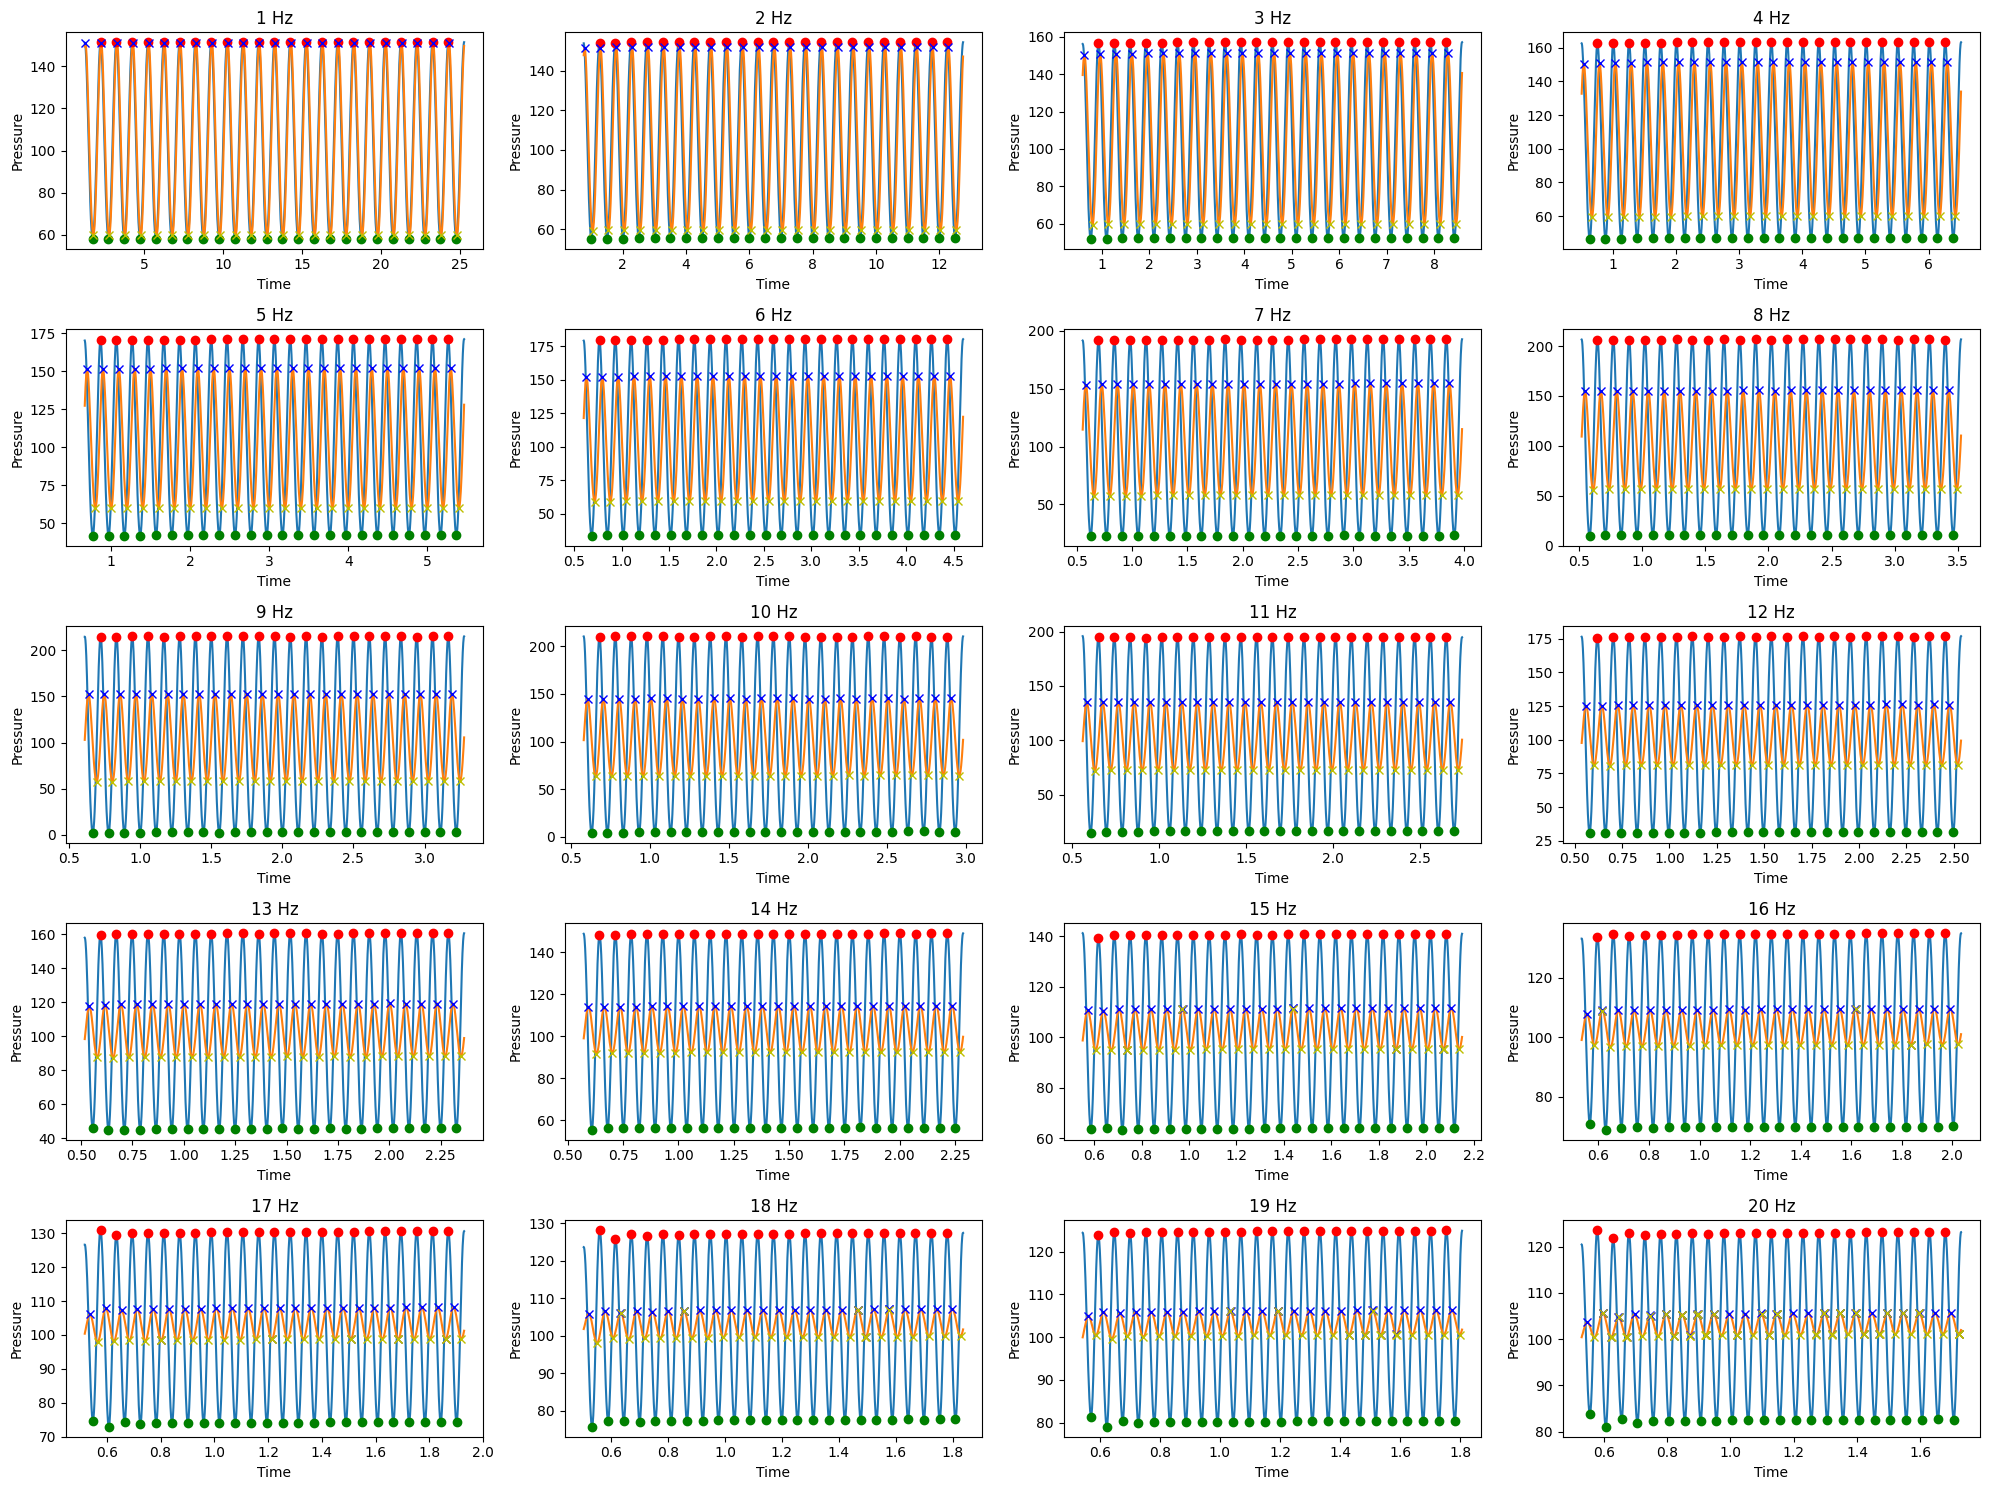

In [ ]:
# Load analysis results
with open('analysis_results.pkl', 'rb') as f:
    analysis_results = pickle.load(f)

# Prepare the plot for peaks and valleys
fig, axes = plt.subplots(5, 4, figsize=(20, 15))
axes = axes.flatten()

# Loop through the analysis results to plot the data
for i, result in enumerate(analysis_results):
    trimmed_time = result['trimmed_time']
    trimmed_pressure1 = result['trimmed_pressure1']
    trimmed_pressure2 = result['trimmed_pressure2']

    # Extract peaks and valleys
    peaks1 = result['peaks1']
    valleys1 = result['valleys1']
    peaks2 = result['peaks2']
    valleys2 = result['valleys2']

    # Plot the trimmed data
    axes[i].plot(trimmed_time, trimmed_pressure1, label='Pressure 1')
    axes[i].plot(trimmed_time, trimmed_pressure2, label='Pressure 2')

    # Mark the peaks and valleys for pressure 1
    axes[i].plot(trimmed_time.iloc[peaks1], trimmed_pressure1.iloc[peaks1], 'ro', label='Peaks 1')
    axes[i].plot(trimmed_time.iloc[valleys1], trimmed_pressure1.iloc[valleys1], 'go', label='Valleys 1')

    # Mark the peaks and valleys for pressure 2
    axes[i].plot(trimmed_time.iloc[peaks2], trimmed_pressure2.iloc[peaks2], 'bx', label='Peaks 2')
    axes[i].plot(trimmed_time.iloc[valleys2], trimmed_pressure2.iloc[valleys2], 'yx', label='Valleys 2')

    axes[i].set_title(f'{i+1} Hz')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Pressure')
    # axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()
